In [1]:
'''
Some libs for math
'''
from math import log2
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import math

frac_cache = dict()

def frac(n:int):
    """
    Calculate the frac: n!
    """
    if n <= 0:
        return 1
    if n in frac_cache:
        return frac_cache[n]
    frac_cache[n] = frac(n-1) * n
    return frac_cache[n]

def comb(n:int,m:int):
    """
    Calculate the combination number: pick m items from n items
    """
    if m>n:
        return 0
    elif m==n:
        return 1
    return (frac(n)/frac(n-m))/frac(m)

random.seed(20220622)

# generate bernoulli r.v.
def bernoulli(p):
    if random.random()<p:
        return 1
    else:
        return 0

# Experiment 1

To get some intuition, we perform the experiment 1. The result may not be shown in the paper.

First, we define a diagonal matrix that shows the joint distribution of ground truth and non-noisy target panel (t=inf)

Note that, in our case, we are picking target noise such with infinite raters we get the ground truth.

$$GT = \begin{bmatrix} Pr[\infty target=0,GT=0] & Pr[\infty target=1,GT=0] \\ Pr[\infty target=0,GT=1] & Pr[\infty target=1,GT=1] \end{bmatrix} = \begin{bmatrix} 0.6 & 0 \\ 0 & 0.4 \end{bmatrix}$$

Then, we define the classifier noise matrix

$$Classifier = \begin{bmatrix} Pr[output=0|GT=0] & Pr[output=0|GT=1] \\ Pr[output=1|GT=0] & Pr[output=1|GT=1] \end{bmatrix}= \begin{bmatrix} q & 1-q \\ 1-q & q\end{bmatrix}$$

Thus, we have the joint distribution of the classifer output and inf-target panel (ground truth).

$$Classifier * GT = \begin{bmatrix} Pr[output=0,\infty target=0] & Pr[output=0,\infty target=1] \\ Pr[output=1,\infty target=0] & Pr[output=1,\infty target=1] \end{bmatrix}
$$

Note that, here the column is ground truth. This matrix is normalized (all entries sum to 1).

Then, we define the k-target noise matrix as

$$Noise = \begin{bmatrix} Pr[k~target = 0|\infty target=0] & Pr[k~target = 1|\infty target=0] \\ Pr[k~target = 0|\infty target=1] & Pr[k~target = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p & 1-p \\ 1-p & p\end{bmatrix}$$

Therefore, the joint distribution of k-target panel and classifier output is

$$Classifier * GT * Noise = \begin{bmatrix} Pr[output=0,k~target=0] & Pr[output=0,k~target=1] \\ Pr[output=1,k~target=0] & Pr[output=1,k~target=1] \end{bmatrix}$$

With this joint distribution, we can easily calculate the Shannon Mutual Information, DMI, Accuracy, and any other scores.

In [2]:
'''
Some code for score calculations.
'''
import numpy as np
from matplotlib import pyplot as plt

def dmi( u ):
    "This calculates the dmi of joint distribution u"
    import numpy.linalg as lin
    return abs(lin.det(u))

def smi( u ):
    "This calculates the smi of joint distribution u"
    import numpy as np
    m,n = u.shape
    v = 0
    ux = np.empty(m)
    uy = np.empty(n)
    for i in range(m):
       	ux[i] = sum(u[i,:])
    for j in range(n):
   	    uy[j] = sum(u[:,j])
    for i in range(m):
   	    for j in range(n):
   		    if u[i][j] != 0:
   			    v = v + u[i][j] * (np.log(u[i][j])-np.log(ux[i]*uy[j]))
    return v

def acc( u ):
    "This calculates the agreement score of joint distribution u"
    return np.trace(u)

source_error = 0.1
dmi_score : difference between performance ratio is  7.771561172376096e-16
smi_score : difference between performance ratio is  0.03296484547638612
agreement_score : difference between performance ratio is  0.07662835249042133

source_error = 0.15
dmi_score : difference between performance ratio is  5.551115123125783e-16
smi_score : difference between performance ratio is  0.018417042367701475
agreement_score : difference between performance ratio is  0.041279669762641746

source_error = 0.2
dmi_score : difference between performance ratio is  8.881784197001252e-16
smi_score : difference between performance ratio is  5.218048215738236e-15
agreement_score : difference between performance ratio is  2.220446049250313e-16

source_error = 0.25
dmi_score : difference between performance ratio is  1.1102230246251565e-15
smi_score : difference between performance ratio is  0.02753258132823988
agreement_score : difference between performance ratio is  0.04848484848484835

sou

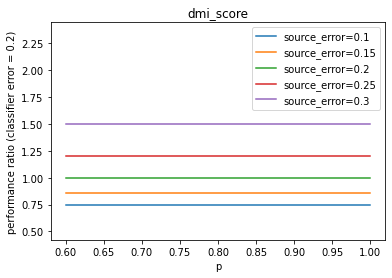

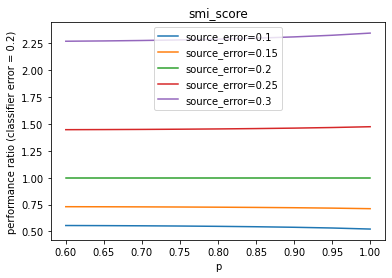

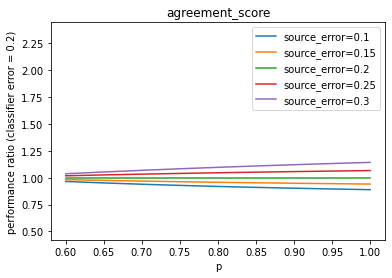

In [3]:
'''
Main code for experiment 1
'''

GT = np.array([[0.6,0.],[0.,0.4]])

# p is target noise, q is the classifier noise, according to the definition above
p_values = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0]
source_error = [0.1,0.15,0.2,0.25,0.3]
q = 0.8

classifier = np.array([[q,1-q],[1-q,q]])
joint = np.dot(classifier,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s in source_error:
    source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)
    dmi_score = []
    smi_score = []
    acc_score = []
    for p in p_values:
        noise = np.array([[p,1-p],[1-p,p]])
        
        u = np.dot(joint,noise)
        v = np.dot(source_panel,noise)
        
        dmi_score.append(dmi(u)/dmi(v))
        smi_score.append(smi(u)/smi(v))
        acc_score.append(acc(u)/acc(v))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_error = '+str(s))
    print('dmi_score : difference between performance ratio is ',np.max(dmi_score)-np.min(dmi_score))
    print('smi_score : difference between performance ratio is ',np.max(smi_score)-np.min(smi_score))
    print('agreement_score : difference between performance ratio is ',np.max(acc_score)-np.min(acc_score))
    print()

    fig_dmi.plot(p_values,dmi_score,label = 'source_error='+str(s))
    fig_smi.plot(p_values,smi_score,label = 'source_error='+str(s))
    fig_acc.plot(p_values,acc_score,label = 'source_error='+str(s))

fig_dmi.legend()
fig_dmi.set_xlabel('p')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('p')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('p')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

Note that although the agreement score does not change a lot, it can't represent the performance of the classifier well. The performance ratio for different source_error is almost the same.

source_error = 0
dmi_score : difference between performance ratio is  4.440892098500626e-16
smi_score : difference between performance ratio is  0.014122560476508228
agreement_score : difference between performance ratio is  0.08760530846766423

source_error = 0.1
dmi_score : difference between performance ratio is  8.881784197001252e-16
smi_score : difference between performance ratio is  0.00861526520149436
agreement_score : difference between performance ratio is  0.049100506657822174

source_error = 0.15
dmi_score : difference between performance ratio is  8.881784197001252e-16
smi_score : difference between performance ratio is  0.005012416028087219
agreement_score : difference between performance ratio is  0.026070487775503803

source_error = 0.2
dmi_score : difference between performance ratio is  1.2212453270876722e-15
smi_score : difference between performance ratio is  8.548717289613705e-15
agreement_score : difference between performance ratio is  2.220446049250313e-16

sour

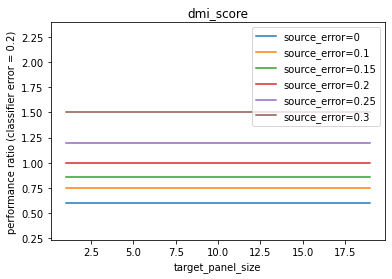

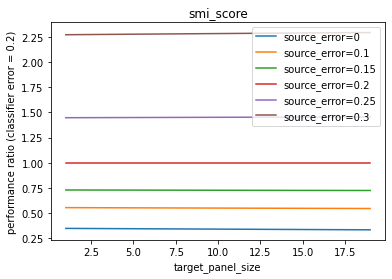

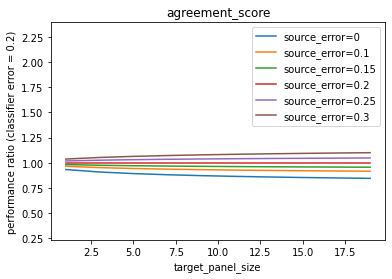

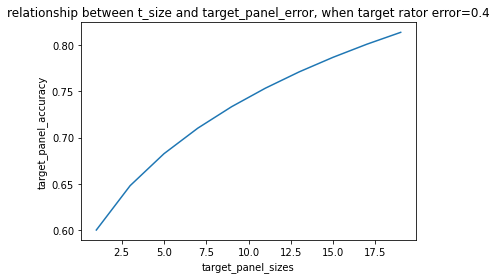

In [4]:
'''
Main code for experiment 1
'''

GT = np.array([[0.6,0.],[0.,0.4]])

target_error = 0.4
target_panel_sizes = [1,3,5,7,9,11,13,15,17,19]
p_values = []
source_error = [0,0.1,0.15,0.2,0.25,0.3]
q = 0.8

classifier = np.array([[q,1-q],[1-q,q]])
joint = np.dot(classifier,GT)

fig_dmi = plt.figure().add_subplot()
fig_smi = plt.figure().add_subplot()
fig_acc = plt.figure().add_subplot()

y_lim_max = 0
y_lim_min = 100

for s in source_error:
    
    source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)
    dmi_score = []
    smi_score = []
    acc_score = []
    for t in target_panel_sizes:
        
        def calc_p(t_error,t_size):
            '''
            Calculate the error of the majority vote among the target panel
            when t_size = 3, it should be 0.6**3 + 3*(0.6**2)*0.4 = 0.648 (checked)
            '''
            ans = 0
            for i in range((t_size+1)//2):
                ans += comb(t_size,i) * ((1-t_error) ** (t_size-i)) * (t_error ** i)
            return ans
            
        p = calc_p (t_error = target_error,t_size = t)
        
        noise = np.array([[p,1-p],[1-p,p]])
        
        u = np.dot(joint,noise)
        v = np.dot(source_panel,noise)
        
        dmi_score.append(dmi(u)/dmi(v))
        smi_score.append(smi(u)/smi(v))
        acc_score.append(acc(u)/acc(v))
        
    
    y_lim_max = np.max([y_lim_max,np.max(dmi_score),np.max(smi_score),np.max(acc_score)])
    y_lim_min = np.min([y_lim_min,np.min(dmi_score),np.min(smi_score),np.min(acc_score)])
    
    print('source_error = '+str(s))
    print('dmi_score : difference between performance ratio is ',np.max(dmi_score)-np.min(dmi_score))
    print('smi_score : difference between performance ratio is ',np.max(smi_score)-np.min(smi_score))
    print('agreement_score : difference between performance ratio is ',np.max(acc_score)-np.min(acc_score))
    print()

    fig_dmi.plot(target_panel_sizes,dmi_score,label = 'source_error='+str(s))
    fig_smi.plot(target_panel_sizes,smi_score,label = 'source_error='+str(s))
    fig_acc.plot(target_panel_sizes,acc_score,label = 'source_error='+str(s))

fig_dmi.legend()
fig_dmi.set_xlabel('target_panel_size')
fig_dmi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_dmi.set_title('dmi_score')

fig_smi.legend()
fig_smi.set_xlabel('target_panel_size')
fig_smi.set_ylabel('performance ratio (classifier error = 0.2)')
fig_smi.set_title('smi_score')

fig_acc.legend()
fig_acc.set_xlabel('target_panel_size')
fig_acc.set_ylabel('performance ratio (classifier error = 0.2)')
fig_acc.set_title('agreement_score')

y_lim_max += 0.1
y_lim_min -= 0.1

fig_dmi.set_ylim(y_lim_min,y_lim_max)
fig_smi.set_ylim(y_lim_min,y_lim_max)
fig_acc.set_ylim(y_lim_min,y_lim_max)

plt.show()

p_values = []

for t in target_panel_sizes:
    p = calc_p (t_error = target_error,t_size = t)
    p_values.append(p)

plt.figure()
plt.plot(target_panel_sizes,p_values)
plt.xlabel('target_panel_sizes')
plt.ylabel('target_panel_accuracy')
plt.title('relationship between t_size and target_panel_error, when target rator error=0.4')
plt.show()

In [5]:
print('Test for calc_p',calc_p(t_error=0.4,t_size=3) == 0.6**3 + 3*(0.6**2)*0.4)

Test for calc_p True


# Experiment 1 with asymmetric noise

First, we define a diagonal matrix that shows the joint distribution of ground truth and non-noisy target panel (t=inf)

Note that, in our case, we are picking target noise such with infinite raters we get the ground truth.

$$GT = \begin{bmatrix} Pr[\infty target=0,GT=0] & Pr[\infty target=1,GT=0] \\ Pr[\infty target=0,GT=1] & Pr[\infty target=1,GT=1] \end{bmatrix} = \begin{bmatrix} 0.6 & 0 \\ 0 & 0.4 \end{bmatrix}$$

Then, we define the classifier noise matrix

$$Classifier = \begin{bmatrix} Pr[output=0|GT=0] & Pr[output=0|GT=1] \\ Pr[output=1|GT=0] & Pr[output=1|GT=1] \end{bmatrix}= \begin{bmatrix} q & 1-q \\ 1-q & q\end{bmatrix}$$

Thus, we have the joint distribution of the classifer output and inf-target panel (ground truth).

$$Classifier * GT = \begin{bmatrix} Pr[output=0,\infty target=0] & Pr[output=0,\infty target=1] \\ Pr[output=1,\infty target=0] & Pr[output=1,\infty target=1] \end{bmatrix}
$$

Note that, here the column is ground truth. This matrix is normalized (all entries sum to 1).

### Here, we introduce asymmetric noise to target panel

$$Noise = \begin{bmatrix} Pr[k~target = 0|\infty target=0] & Pr[k~target = 1|\infty target=0] \\ Pr[k~target = 0|\infty target=1] & Pr[k~target = 1|\infty target=1] \end{bmatrix} = \begin{bmatrix} p_1 & 1-p_1 \\ 1-p_2 & p_2\end{bmatrix}$$

Therefore, the joint distribution of k-target panel and classifier output is

$$Classifier * GT * Noise = \begin{bmatrix} Pr[output=0,k~target=0] & Pr[output=0,k~target=1] \\ Pr[output=1,k~target=0] & Pr[output=1,k~target=1] \end{bmatrix}$$

With this joint distribution, we can easily calculate the Shannon Mutual Information, DMI, Accuracy, and any other scores.

[[0.85714286 0.85714286 0.85714286 ... 0.85714286 0.85714286 0.85714286]
 [0.85714286 0.85714286 0.85714286 ... 0.85714286 0.85714286 0.85714286]
 [0.85714286 0.85714286 0.85714286 ... 0.85714286 0.85714286 0.85714286]
 ...
 [0.85714286 0.85714286 0.85714286 ... 0.85714286 0.85714286 0.85714286]
 [0.85714286 0.85714286 0.85714286 ... 0.85714286 0.85714286 0.85714286]
 [0.85714286 0.85714286 0.85714286 ... 0.85714286 0.85714286 0.85714286]]


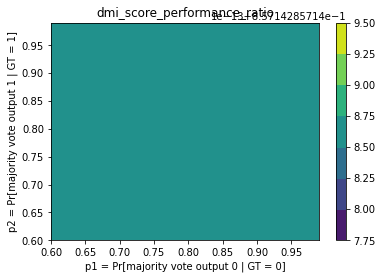

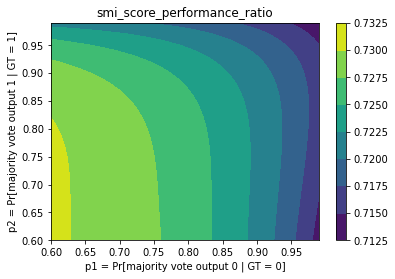

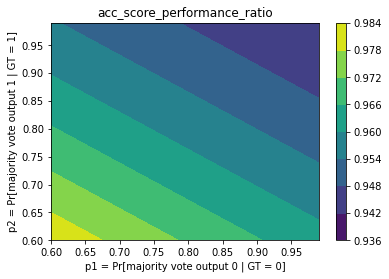

In [16]:
GT = np.array([[0.6,0.],[0.,0.4]])

# p is target noise, q is the classifier noise, according to the definition above
p_values = [i*0.01+0.6 for i in range(40)]
q = 0.8

classifier = np.array([[q,1-q],[1-q,q]])
joint = np.dot(classifier,GT)

y_lim_max = 0
y_lim_min = 100

s=0.15
source_panel = np.dot(np.array([[1-s,s],[s,1-s]]),GT)

dmi_contour = []
smi_contour = []
acc_contour = []

for p1 in p_values:
    dmi_score = []
    smi_score = []
    acc_score = []
    for p2 in p_values:
        noise = np.array([[p1,1-p1],[1-p2,p2]])

        u = np.dot(joint,noise)
        v = np.dot(source_panel,noise)

        dmi_score.append(dmi(u)/dmi(v))
        smi_score.append(smi(u)/smi(v))
        acc_score.append(acc(u)/acc(v))

    dmi_contour.append(dmi_score)
    smi_contour.append(smi_score)
    acc_contour.append(acc_score)

dmi_contour = np.array(dmi_contour)
smi_contour = np.array(smi_contour)
acc_contour = np.array(acc_contour)

# make the contours
S,V = np.meshgrid(p_values,p_values)

plt.contourf(S,V,dmi_contour)
plt.xlabel('p1 = Pr[majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[majority vote output 1 | GT = 1]')
plt.title('dmi_score_performance_ratio')

plt.colorbar()
plt.show()

plt.contourf(S,V,smi_contour)
plt.xlabel('p1 = Pr[majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[majority vote output 1 | GT = 1]')
plt.title('smi_score_performance_ratio')

plt.colorbar()
plt.show()

plt.contourf(S,V,acc_contour)
plt.xlabel('p1 = Pr[majority vote output 0 | GT = 0]')
plt.ylabel('p2 = Pr[majority vote output 1 | GT = 1]')
plt.title('acc_score_performance_ratio')

plt.colorbar()
plt.show()


# Experiment 2

Generate sythetic dataset, and then calculate the scores

The first code block is for some simple math. The second code block is for scores.



In [7]:
'''
Scorers
'''



def agreement_score(W,hard_classifier,t_size):
    ans = 0
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr[int(hard_classifier[i])]
        
    return ans/W.shape[0]

def cross_entropy_score(W,soft_classifier,t_size):
    ans = 0
    item_size = W.shape[0]
    tot_count = W.shape[1]
    
    for i in range(item_size):
        count_pos = np.sum(W[i])
        
        # pr is the probability that majority vote outputs 0 or 1
        pr = np.zeros(2)
        for k in range(t_size//2+1):
            pr[0] += comb(count_pos,k)*comb(tot_count-count_pos,t_size-k)
            pr[1] += comb(count_pos,t_size-k)*comb(tot_count-count_pos,k)
        pr /= comb(tot_count,t_size)
        # check pr
        if np.sum(pr) > 1+0.001 or np.sum(pr) < 1-0.001:
            print('Error')
            raise Error
            
        # scorer
        ans += pr[0]*log2(soft_classifier[i,0]) + pr[1]*log2(soft_classifier[i,1])
        
    return ans/W.shape[0]

# import unittest

# class TestScoringFunctions(unittest.TestCase):
#     W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    
#     def test_agreement_score(self):
#         '''
#         majority of 3 raters
#         score = 1/4 * (1/2 + 1 + 1 + 0)
#         '''
#         t_size = 3
#         hard_classifier = np.array([1,1,1,1])
#         score = agreement_score(W=self.W,hard_classifier=hard_classifier,t_size=t_size)
#         print(score)
#         self.asserAlmostEqual(score,0.625,delta=0.001)
    
#     def test_CE_score(self):
#         '''
#         majority of 3 raters
#         score = 1/4 * (1/2 + 1 + 1 + 0)
#         '''
#         t_size = 3
#         soft_classifier = np.array([[0.2,0.8],[0.3,0.7],[0.6,0.4],[0.2,0.8]])
#         score = cross_entropy_score(W=self.W,soft_classifier=soft_classifier,t_size=t_size)
#         ground_truth = 1/4 * (log2(0.2)*1/2+log2(0.8)*1/2+log2(0.7)*1+log2(0.4)*1+log2(0.2)*1)
#         print(score,ground_truth)
#         self.asserAlmostEqual(score,ground_truth,delta=0.001)

def test_agreement_score():
    '''
    majority of 3 raters
    score = 1/4 * (1/2 + 1 + 1 + 0)
    '''
    W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    t_size = 3
    hard_classifier = np.array([1,1,1,1])
    score = agreement_score(W=W,hard_classifier=hard_classifier,t_size=t_size)
    print('test_agreement_score',score == 1/4 * (1/2 + 1 + 1 + 0))

def test_CE_score():
    '''
    majority of 3 raters
    score = 1/4 * (log2(0.2)*1/2 + log2(0.8)*1/2 + log2(0.7)*1 + log2(0.4)*1 + log2(0.2)*1)
    '''
    W = np.array([[1,0,0,1],[1,1,1,0],[0,1,1,1],[0,0,0,0]])
    t_size = 3
    soft_classifier = np.array([[0.2,0.8],[0.3,0.7],[0.6,0.4],[0.2,0.8]])
    score = cross_entropy_score(W=W,soft_classifier=soft_classifier,t_size=t_size)
    ground_truth = 1/4 * (log2(0.2)*1/2+log2(0.8)*1/2+log2(0.7)*1+log2(0.4)*1+log2(0.2)*1)
    print('test_CE_score', score == ground_truth)

test_agreement_score()
test_CE_score()


test_agreement_score True
test_CE_score True


### Dataset Generation

There are two states 0,1.

For the hard classifier, with probability classifier_error, the state with be reversed. Otherwises, classifier will output the ground truth.

For the soft classifier, when ground truth is 0, it will output (1-classifier_error, classifier_error), when ground truth is 1, it will output (classifier_error, 1-classifier_error)

For the rater, the target raters and source raters have the same error.

In [8]:
# parameters
item_size = 300
rater_size = 20

# split target and sourse raters
target_raters = dict()
source_raters = dict()

# classifier output, an integer, 0/1
hard_classifier_output = np.zeros(item_size)
# classifier output
soft_classifier_output = np.zeros((item_size,2))

calibrated_output = np.zeros((item_size,2))
# ground truth
ground_truth = np.zeros(item_size)

# classifier error and rater error
prior = 0.5
classfier_error = 0.2

rater_errors = [0,0.15,0.2,0.25,0.3,0.35]

# generate dataset
def classifier_data():
    for i in range(item_size):
        item_state = bernoulli(prior)
        ground_truth[i] = item_state
        # use mod as xor
        hard_classifier_output[i] = (ground_truth[i] + bernoulli(classfier_error))%2
        # small trick
        soft_classifier_output[i,0] = abs(1 - ground_truth[i] - classfier_error)
        soft_classifier_output[i,1] = abs(ground_truth[i] - classfier_error)

classifier_data()

for rater_error in rater_errors:

    def synthetic_data():
        # W is the rater dataset
        W = np.zeros((item_size,rater_size))
        for i in range(item_size):
            for j in range(rater_size):
                W[i][j] = (ground_truth[i] + bernoulli(rater_error))%2
        return W
    
    target_raters[rater_error] = synthetic_data()
    source_raters[rater_error] = synthetic_data()

# target sizes
# t is odd to avoid tie
t_sizes = [1,3,5,7,9,11,13,15,17]

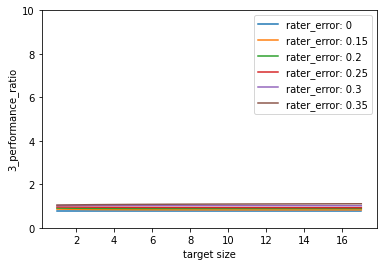

In [9]:
'''
Draw the performance ratio for agreement score
'''

plt.figure()
for r_error in rater_errors:
    
    # Calculate the agreement score of the classifier 
    classifier_acc = []
    for t in t_sizes:
        W = target_raters[r_error]
        classifier_acc.append(agreement_score(W,hard_classifier=hard_classifier_output,t_size=t))

    # Source size 3
    W = source_raters[r_error]
    s=3
    majority_output = np.zeros(item_size)
    W_s = W[...,:s]
    majority_output = np.sum(W_s,axis=1) > (np.ones(item_size)*(s/2.0))

    # Calculate the agreement score of the source majority
    data = []
    for t in t_sizes:
        data.append(agreement_score(W=target_raters[r_error],hard_classifier=majority_output,t_size=t))
    classifier_acc = np.array(classifier_acc)/np.array(data)
    plt.plot(t_sizes,classifier_acc,label = 'rater_error: '+str(r_error))

plt.legend()
plt.ylim(0,10)
plt.xlabel('target size')
plt.ylabel(str(s)+'_performance_ratio')
plt.show()

### Performance (improvement) ratio for ABC+CE

Here we draw the figure for the performance improvement ratio for ABC+CE. The name need to be discussed later. The key point is following the Theorem 1 and 2 in the seq paper.

THEOREM 1 (ABC+CE estimates mutual information). For any fixed set of raters and any $k<\mid$ raters $\mid$, almost surely
$$
\lim _{|I| \rightarrow \infty} \operatorname{SPC}(\mathbf{W}, \mathrm{ABC}(\cdot), \operatorname{CE}(\cdot))_{k}-\operatorname{SPC}(\mathbf{W}, \operatorname{ABC}(\cdot), \operatorname{CE}(\cdot))_{0}=\operatorname{MI}\left(Y_{k+1} ; Y_{1}, Y_{2}, \cdots, Y_{k}\right) .
$$

THEOREM 2 (CE+CALIBRATED CLASSIFIER estimates mutual information). For any calibrated soft classifier $h$, and for any fixed set of raters, almost surely
$$
\lim _{|I| \rightarrow \infty} \operatorname{HScore}(h(I), \mathbf{W}, \operatorname{CE}(\cdot))-\operatorname{SPC}(\mathbf{W}, \operatorname{ABC}(\cdot), \operatorname{CE}(\cdot))_{0}=\operatorname{MI}(h(X) ; Y)
$$


#### Calibration

First, we perform calibration for the Classifier. We use the logistic regreesion to do calibration.

In [10]:
def calibrate(t_size, raters):

    # the majority vote of source panel
    majority_output = np.sum(raters,axis=1) > (np.ones(item_size)*(t_size/2.0))
    
    # logistic regression
    clf = LogisticRegression(random_state=0).fit(soft_classifier_output[:,1:].reshape(-1,1), majority_output.flatten())
    calibrated_output = clf.predict_log_proba(soft_classifier_output[:,1:])
    
    # recover the probability
    calibrated_soft_classifier = np.zeros((item_size,2))
    for i in range(item_size):
        calibrated_soft_classifier[i,1] = math.exp(calibrated_output[i,1])
        calibrated_soft_classifier[i,0] = math.exp(calibrated_output[i,0])
    
    return calibrated_soft_classifier

#### ABC combiner

Then, we define the ABC combiner for target_size > 1

note that we need to make sure that s+t < rater_size

In [11]:
# memoize the sum_of_prob to accelerate
# initial it for different W
sum_of_prob_memo = dict()

def sum_of_prob(W,num_pos,num_neg):
    if (num_pos,num_neg) in sum_of_prob_memo:
        return sum_of_prob_memo[(num_pos,num_neg)]
    
    item_size = W.shape[0]
    rater_size = W.shape[1]
    W_count = np.sum(W,axis=1)
    
    if (num_pos,num_neg) in sum_of_prob_memo:
        return sum_of_prob_memo[(num_pos,num_neg)]

    v = 0
    for i in range(item_size):
        v += prob_of_one_item(W_count[i],rater_size-W_count[i],num_pos,num_neg)
        
    sum_of_prob_memo[(num_pos,num_neg)] = v
    
    return v

def prob_of_one_item(W_tot_pos,W_tot_neg,num_pos,num_neg):
    if (num_pos>W_tot_pos) or (num_neg>W_tot_neg):
        return 0
    return (comb(W_tot_neg,num_neg)*frac(num_neg)*comb(W_tot_pos,num_pos)*frac(num_pos)*1.0/(comb(W_tot_neg+W_tot_pos,num_pos+num_neg)*frac(num_neg+num_pos)))

def label_seq_prob(W,num_pos,num_neg,exclude_id=-1):
    if exclude_id == -1:
        return sum_of_prob(W=W,num_pos=num_pos,num_neg=num_neg)/W.shape[0]
    
    return (sum_of_prob(W=W,num_pos=num_pos,num_neg=num_neg)-prob_of_one_item(np.sum(W[exclude_id]),W.shape[1]-np.sum(W[exclude_id]),num_pos,num_neg))/(W.shape[0]-1)
    
'''
ABC for target panel size >= 1
'''
def ABC(W,num_pos,num_neg,t_size,exclude_id=-1):
    pr = np.zeros(2)
    # for every possible target panel of 0 or 1
    # note that we need to make sure that s+t < rater_size
    for i in range((t_size+1)//2):
        pr[0] += comb(t_size,i)*label_seq_prob(W=W,num_pos=num_pos+i,num_neg=num_neg+(t_size-i),exclude_id=exclude_id)
        pr[1] += comb(t_size,i)*label_seq_prob(W=W,num_pos=num_pos+(t_size-i),num_neg=num_neg+i,exclude_id=exclude_id)
        
    pr /= label_seq_prob(W=W,num_pos=num_pos,num_neg=num_neg,exclude_id=exclude_id)
    return pr

def test_for_ABC():
    '''
    0 is possible from item 3,4,8 with prob 2/11, from item 5,6 with prob 1/11, from item 7 with prob 3/11
    ABC output 0 with prob 3 * 2/11 * 1/2 + 2 * 1/11 * 0 + 3/11 * 1 = 6/11
    '''
    W = [[1,1,1],[1,1,1],[1,0,0],[1,0,0],[1,0,1],[0,1,1],[0,0,0],[0,0,1]]
    W = np.array(W)
    print('test_for_ABC_1',ABC(W=W,num_pos=0,num_neg=1,t_size=1)[0]==6/11)
    
    '''
    0 is possible from item 4,8 with prob 2/9, from item 5,6 with prob 1/9, from item 7 with prob 3/9
    ABC output 0 with prob 2 * 2/9 * 1/2 + 2 * 1/9 * 0 + 3/9 * 1 = 5/9
    '''
    W = [[1,1,1],[1,1,1],[1,0,0],[1,0,0],[1,0,1],[0,1,1],[0,0,0],[0,0,1]]
    W = np.array(W)
    print('test_for_ABC_2',ABC(W=W,num_pos=0,num_neg=1,t_size=1,exclude_id = 2)[0]==5/9)
    

test_for_ABC()

test_for_ABC_1 True
test_for_ABC_2 True


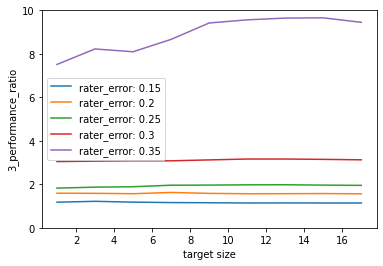

In [12]:
plt.figure()
for r_error in rater_errors:
    
    #clean the memo for different W
    sum_of_prob_memo = dict()
    
    # CE will have problem when r_error = 0
    if r_error < 0.01:
        continue
        
    classifier_acc = []
    prior_pred = np.ones((item_size,2)) * 0.5

    # The CE score for the calibrated classifier
    for t in t_sizes:
        calibrated_soft_classifier = calibrate(t, source_raters[r_error][:,:t])
        classifier_acc.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=calibrated_soft_classifier,t_size=t))

    W = source_raters[r_error]
    s = 3 # s + max(t_sizes) = 20
    W_s_count = np.sum(W[...,:s],axis=1)
    ABC_score = []
    prior_score = []
    
    for t in t_sizes:
        abc_output = np.zeros((item_size,2))
        prior_output = np.zeros((item_size,2))

        for i in range(item_size):
            abc_output[i] = ABC(W = W,num_pos = W_s_count[i],num_neg = s-W_s_count[i],t_size = t,exclude_id = i)
            prior_output[i] = ABC(W = W,num_pos = 0,num_neg = 0,t_size = t,exclude_id = i)
        
        ABC_score.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=abc_output,t_size=t))
        prior_score.append(cross_entropy_score(W=target_raters[r_error],soft_classifier=prior_output,t_size=t))
    
    performance_ratio = (np.array(classifier_acc)-np.array(prior_score))/(np.array(ABC_score)-np.array(prior_score))
    plt.plot(t_sizes,performance_ratio,label = 'rater_error: '+str(r_error))


plt.legend()
plt.ylim(0,10)
plt.xlabel('target size')
plt.ylabel(str(s)+'_performance_ratio')
plt.show()
